In [2]:
# test different pre-trained models against the images used as "test" set during the training

#Importation des packages (il faut encore en supprimer quelques uns)
import numpy as np 
from keras.applications import  resnet50
from sklearn import metrics 
import os

import pandas as pd # Pour manipuler des DataFrames pandas

import matplotlib.pyplot as plt # Pour l'affichage d'images
from matplotlib import cm # Pour importer de nouvelles cartes de couleur
%matplotlib inline

from keras.models import Sequential # Pour construire un réseau de neurones
from keras.layers import Dense, Conv2D # Pour instancier une couche dense
from keras.utils import np_utils

from keras.models import Sequential
from keras.layers import Dense, Activation,GlobalAveragePooling2D, MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D

import cv2
import keras
from numpy.random import seed
import tensorflow

from keras.preprocessing.image import ImageDataGenerator
import itertools # Pour créer des iterateurs

from sklearn import linear_model, preprocessing 



%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import time, cv2
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split

from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras import backend as K
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.applications.vgg16 import preprocess_input
from keras.models import load_model
sns.heatmap
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn

In [3]:
#Paramètres

base_img_paths="/mnt/VegaSlowDataDisk/Backups/VegaFastExtension/c3po_all/c3po/Images_aquises/"
generateur_path='/mnt/VegaSlowDataDisk/Backups/VegaFastExtension/c3po_all/c3po/Images_aquises/generateur_bigger.csv'
#generateur_path='/mnt/VegaSlowDataDisk/c3po/Chaine_de_traitement/Train_imagettes_annotées/type_oiseau/Materiel/generateur.csv'
test_size=0.1
epochs=200
batch_size = 600
zoom_range = 1.25
horizontal_flip = True
Minimum_Number_Class=100
dropout_rate=0.1
#steps_per_epoch=len(data_train)//batch_size
steps_per_epoch=1
#validation_steps=len(data_test)//batch_size
validation_steps=1

#Importation du générateur contenant les chemins pour les imgettes grossies
#df=pd.read_csv("/home/marcpozzo/Desktop/c3po/Images_aquises/generateur.csv")
df=pd.read_csv(generateur_path)
df.drop('labels',inplace=True,axis=1)
df.shape


#Récupération des labels à partir du fichier
df["class"].unique()
for c in df:
    print(''+c+':',len(df[c].unique()))
df["class"].unique()

All_Unique=df["class"].unique()
Utilisable=[]
for i in df["class"].unique():
    if df["class"][df["class"]==i].count()>Minimum_Number_Class:
        Utilisable.append(i)
Utilisable
Non_Utilisable=set(All_Unique)-set(Utilisable)
Non_Utilisable
for i in Non_Utilisable:
    df=df[df["class"]!=i]
df=df[df["class"]!="oiseau"]  
df["class"].unique()


for i in range(len(df["class"])):
    image_name=df["img_paths"].iloc[i]
    df["img_paths"].iloc[i]=os.path.join(base_img_paths,image_name)
    
#df.shape
#df[df["img_paths"]=='/home/marcpozzo/Desktop/c3po_all/c3po_interface_mark/c3po/Images_aquises/Rec_images_bigger/EK000414_3_pigeon_178.JPG']

seed(1)
tensorflow.random.set_seed(2)

data_train,data_test= train_test_split(df,stratify=df["class"], test_size=test_size,random_state=42)
train_data_generator = ImageDataGenerator(
        preprocessing_function = preprocess_input,
        # data augmentation
        rotation_range = 10,
        zoom_range = zoom_range,
        horizontal_flip = horizontal_flip
        )

test_data_generator = ImageDataGenerator(
    preprocessing_function = preprocess_input)




train_generator = train_data_generator.flow_from_dataframe(dataframe=data_train,
                                                          directory="",
                                                           x_col = "img_paths",
                                                           class_mode ="sparse",
                                                          target_size = (28 , 28), 
                                                          batch_size = batch_size)


test_generator = test_data_generator.flow_from_dataframe(dataframe=data_test,
                                                          directory="",
                                                           x_col = "img_paths",
                                                           class_mode ="sparse",
                                                          target_size = (28 , 28), 
                                                          batch_size = batch_size)


class: 13
img_paths: 6220
Found 5369 validated image filenames belonging to 6 classes.
Found 597 validated image filenames belonging to 6 classes.


In [4]:
df["img_paths"].iloc[0]

'/mnt/VegaSlowDataDisk/Backups/VegaFastExtension/c3po_all/c3po/Images_aquises/Rec_images_bigger/DSCF0029_ground_1.JPG'

In [5]:
#Conversion de l'image en array de format 28,28
def convert_image(X):
    X_img=[]
    for image in X:
        # Load image
        img=cv2.imread(image)
        # Resize image
        img=cv2.resize(img,(28,28))
        # for the black and white image
        if img.shape==(28, 28):
            img=img.reshape([28,28,1])
            img=np.concatenate([img,img,img],axis=2)
        # cv2 load the image BGR sequence color (not RGB)
        X_img.append(img[...,::-1])
    return np.array(X_img)

#Creation of dictionnary according to generator classes to convert the number labels (0,1,2,3,4,5) to tring labels ("autre","corbeau",....)
def metrique(arg_predict):
    dictionnaire=train_generator.class_indices
    dictionnaire_inv = {v: k for k, v in dictionnaire.items()}
    
    Keys=[]
    Values=[]

    for i in range(len(arg_predict)) :
        Keys.append(arg_predict[i])
        Values.append(dictionnaire_inv[arg_predict[i]])

    #print(metrics.classification_report(Y_test, Values))
    return Values

X_train_img = convert_image(data_train.img_paths)
Y_train = data_train['class']

# Load the images test
X_test_img = convert_image(data_test.img_paths)
Y_test = data_test['class']

In [7]:
#Testing all the neurone modes and display the principal metrics and crosstables.
##The best score is 6c_rob trained with original dataset. 
folder="zoom_models/"
Neurones=['drop_out.50']
for n in Neurones:
    model = load_model(folder+n)
    intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[-1].output)
    X_test_features = intermediate_layer_model.predict(preprocess_input(X_test_img))
    arg_predict=X_test_features.argmax(axis=1)


    pred=metrique(arg_predict)
    print("")
    print("Mesures de qualité du modèle: ", n)
    print("")
    print(n,metrics.classification_report(Y_test,pred))
    print("")
    print("table de cotingeance pour le modeèle: ", n)
    print("")
    print(pd.crosstab(Y_test,np.array(pred)))


Mesures de qualité du modèle:  drop_out.50

drop_out.50               precision    recall  f1-score   support

       autre       0.94      0.99      0.96       342
   chevreuil       0.75      0.86      0.80        14
   corneille       0.93      0.93      0.93       107
      faisan       0.87      0.82      0.84        33
       lapin       0.90      0.50      0.64        18
      pigeon       0.99      0.88      0.93        83

    accuracy                           0.93       597
   macro avg       0.90      0.83      0.85       597
weighted avg       0.94      0.93      0.93       597


table de cotingeance pour le modeèle:  drop_out.50

col_0      autre  chevreuil  corneille  faisan  lapin  pigeon
class                                                        
autre        338          0          0       3      1       0
chevreuil      2         12          0       0      0       0
corneille      5          3         99       0      0       0
faisan         5          0          

In [8]:
tab_cont=pd.crosstab(Y_test,np.array(pred))

In [9]:
tab_cont

col_0,autre,chevreuil,corneille,faisan,lapin,pigeon
class,,,,,,
autre,338,0,0,3,1,0
chevreuil,2,12,0,0,0,0
corneille,5,3,99,0,0,0
faisan,5,0,0,27,0,1
lapin,3,1,4,1,9,0
pigeon,6,0,4,0,0,73


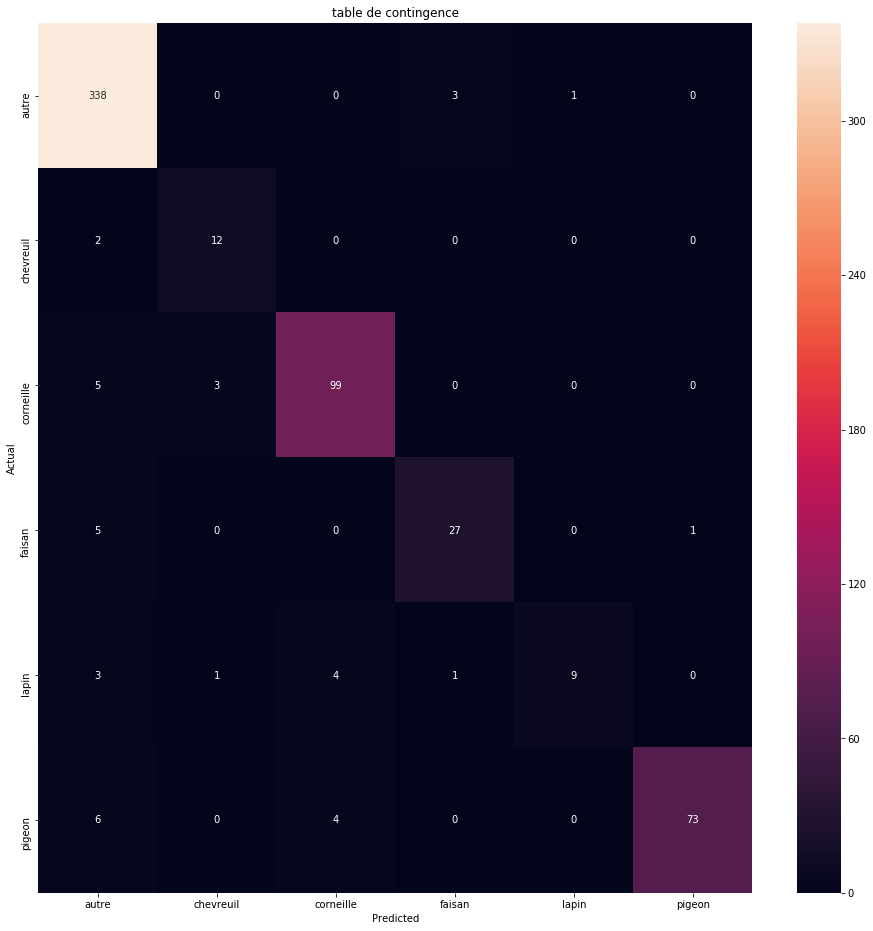

In [13]:
    #conf_mat = confusion_matrix(valid_y, y_hat)
    fig, ax = plt.subplots(figsize=(16,16))
    seaborn.heatmap(a, annot=True, fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title("table de contingence");
    #plt.figure(figsize=(16,16))
    plt.show()
    